In [3]:
# Import Libraries and Configuration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Set figure size defaults
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("✅ Environment setup complete!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

✅ Environment setup complete!
Pandas version: 2.2.3
NumPy version: 1.26.4


In [5]:
# Load StackOverflow Data
# Download from: https://insights.stackoverflow.com/survey
# Choose the most recent year available

# Load the data
df = pd.read_csv('survey_results_public.csv')
df_schema = pd.read_csv('survey_results_schema.csv')

print("Dataset loaded successfully!")
print(f"Shape: {df.shape}")
print("\n" + "="*50)
print("SCHEMA PREVIEW:")
print("="*50)
print(df_schema.head(10))


Dataset loaded successfully!
Shape: (65437, 114)

SCHEMA PREVIEW:
      qid             qname  \
0    QID2        MainBranch   
1  QID127               Age   
2  QID296        Employment   
3  QID308        RemoteWork   
4  QID341             Check   
5  QID297  CodingActivities   
6   QID25           EdLevel   
7  QID276         LearnCode   
8  QID281   LearnCodeOnline   
9  QID331           TechDoc   

                                            question force_resp type selector  
0  Which of the following options best describes ...       True   MC     SAVR  
1                                 What is your age?*       True   MC     SAVR  
2  Which of the following best describes your cur...       True   MC     MAVR  
3  Which best describes your current work situation?      False   MC     SAVR  
4  Just checking to make sure you are paying atte...       True   MC     SAVR  
5  Which of the following best describes the code...      False   MC     MAVR  
6  Which of the following best d

In [6]:
# Cell 3: Basic Dataset Overview
print("🔍 INITIAL DATA INSPECTION")
print("="*50)

# Basic info
print(f"📊 Dataset Shape: {df.shape}")
print(f"📈 Rows: {df.shape[0]:,}")
print(f"📋 Columns: {df.shape[1]}")
print(f"💾 Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\n" + "="*50)
print("📋 COLUMN INFORMATION:")
print("="*50)
print(df.info())

print("\n" + "="*50)
print("🎯 DATA TYPES BREAKDOWN:")
print("="*50)
print(df.dtypes.value_counts())

🔍 INITIAL DATA INSPECTION
📊 Dataset Shape: (65437, 114)
📈 Rows: 65,437
📋 Columns: 114
💾 Memory Usage: 450.49 MB

📋 COLUMN INFORMATION:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65437 entries, 0 to 65436
Columns: 114 entries, ResponseId to JobSat
dtypes: float64(13), int64(1), object(100)
memory usage: 56.9+ MB
None

🎯 DATA TYPES BREAKDOWN:
object     100
float64     13
int64        1
Name: count, dtype: int64


🚨 MISSING DATA ANALYSIS
Columns with missing data: 109
Total missing values: 2,890,957

Top 10 columns with missing data:
                                                      Column  Missing_Count  \
AINextMuch less integrated        AINextMuch less integrated          64289   
AINextLess integrated                  AINextLess integrated          63082   
AINextNo change                              AINextNo change          52939   
AINextMuch more integrated        AINextMuch more integrated          51999   
EmbeddedAdmired                              EmbeddedAdmired          48704   
EmbeddedWantToWorkWith                EmbeddedWantToWorkWith          47837   
EmbeddedHaveWorkedWith                EmbeddedHaveWorkedWith          43223   
ConvertedCompYearly                      ConvertedCompYearly          42002   
AIToolNot interested in Using  AIToolNot interested in Using          41023   
AINextMore integrated                  AINextMore integrated          41009   

        

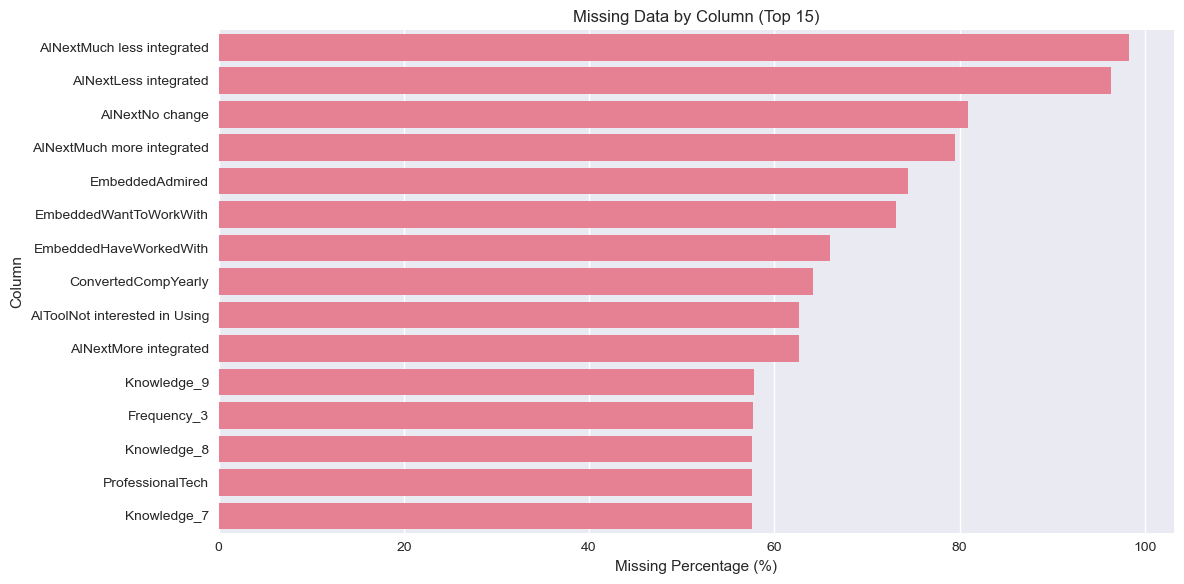

In [7]:
# Missing Data Analysis
print("🚨 MISSING DATA ANALYSIS")
print("="*50)

# Calculate missing percentages
missing_data = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df)) * 100
})
missing_data = missing_data[missing_data['Missing_Count'] > 0].sort_values('Missing_Percentage', ascending=False)

print(f"Columns with missing data: {len(missing_data)}")
print(f"Total missing values: {df.isnull().sum().sum():,}")

if len(missing_data) > 0:
    print("\nTop 10 columns with missing data:")
    print(missing_data.head(10))
    
    # Visualize missing data
    plt.figure(figsize=(12, 6))
    sns.barplot(data=missing_data.head(15), x='Missing_Percentage', y='Column')
    plt.title('Missing Data by Column (Top 15)')
    plt.xlabel('Missing Percentage (%)')
    plt.tight_layout()
    plt.show()
else:
    print("🎉 No missing data found!")

In [8]:
# Data Quality Checks
print("✅ DATA QUALITY ASSESSMENT")
print("="*50)

# Check for duplicates
duplicate_count = df.duplicated().sum()
print(f"Duplicate rows: {duplicate_count}")

# Identify numerical and categorical columns
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

print(f"\n📊 Numerical columns: {len(numerical_cols)}")
print(f"📝 Categorical columns: {len(categorical_cols)}")

print(f"\nNumerical columns: {numerical_cols[:10]}{'...' if len(numerical_cols) > 10 else ''}")
print(f"Categorical columns: {categorical_cols[:10]}{'...' if len(categorical_cols) > 10 else ''}")

# Check for constant columns (all same value)
constant_cols = []
for col in df.columns:
    if df[col].nunique() == 1:
        constant_cols.append(col)

if constant_cols:
    print(f"\n⚠️ Constant columns (consider removing): {constant_cols}")
else:
    print("\n✅ No constant columns found")


✅ DATA QUALITY ASSESSMENT
Duplicate rows: 0

📊 Numerical columns: 14
📝 Categorical columns: 100

Numerical columns: ['ResponseId', 'CompTotal', 'WorkExp', 'JobSatPoints_1', 'JobSatPoints_4', 'JobSatPoints_5', 'JobSatPoints_6', 'JobSatPoints_7', 'JobSatPoints_8', 'JobSatPoints_9']...
Categorical columns: ['MainBranch', 'Age', 'Employment', 'RemoteWork', 'Check', 'CodingActivities', 'EdLevel', 'LearnCode', 'LearnCodeOnline', 'TechDoc']...

⚠️ Constant columns (consider removing): ['Check']


In [9]:
# Check salary column
salary_col = 'ConvertedCompYearly'  # or 'ConvertedComp' depending on year
print(f"Salary data available: {df[salary_col].notna().sum():,} developers")
print(f"Salary range: ${df[salary_col].min():,.0f} - ${df[salary_col].max():,.0f}")
print(f"Missing salary data: {df[salary_col].isna().sum():,} developers")

# Check key features
key_features = ['YearsCodePro', 'EdLevel', 'Country', 'DevType', 'OrgSize']
for feature in key_features:
    if feature in df.columns:
        print(f"{feature}: {df[feature].notna().sum():,} responses")

Salary data available: 23,435 developers
Salary range: $1 - $16,256,603
Missing salary data: 42,002 developers
YearsCodePro: 51,610 responses
EdLevel: 60,784 responses
Country: 58,930 responses
DevType: 59,445 responses
OrgSize: 47,480 responses
